# Tutorial: Programming with Pulser

This tutorial demonstrates how to use Pulser to program the evolution of a quantum system. In a first part, we excite one atom from its ground state to its excited state using a constant pulse. In a second part, we show how to prepare a quantum system of 9 atoms in an anti-ferromagnetic state using time-dependent pulses.

This tutorial follows the step-py-step guide on how to create a quantum program using Pulser that is provided in the [programming page](../programming.md). For more information regarding the steps followed and the mathematical objects at stake, please refer to this page.

In [1]:
import numpy as np
import pulser
from matplotlib import pyplot as plt

## Preparing an atom in the Rydberg state

As presented in ["Programming a neutral-atom QPU"](../programming.md), Pulser enables you to program [an Hamiltonian](../programming.md) composed of an [interaction Hamiltonian](../programming.md) and a [drive Hamiltonian](../programming.md).

Let's program this Hamiltonian $H$ such that an atom initially in the ground state $\left|g\right>$ is measured in the Rydberg state $\left|r\right>$ after a time $\Delta t$.

Since we are working with a single atom, there is no [interaction Hamiltonian](../programming.md). In this specific example, $H=H^D$. For a simple pulse having a duration $\Delta t$, a constant amplitude along time $\Omega$, detuning $\delta=0$ and phase $\phi=0$ [the Hamiltonian between 0 and Δt is](../programming.md):

$$ H(t) = \hbar\frac{\Omega}{2} (|g\rangle\langle r| + |r\rangle\langle g|)$$

<details>

<summary>To find the atom in the Rydberg state at the end of the program, we choose $\Delta t=1000\ ns$ and $\Omega=\pi\ rad/\mu s$:</summary>


<details>

<summary> We can use the Bloch sphere representation </summary>

The pulse being of duration $\Delta t$, of detuning $\delta=0$, of phase $\phi=0$ and constant amplitude $\Omega$, the pulse will make the vector representing the state rotate by an angle $\Omega \Delta t$ around the axis $(1, 0, 0)$. To go from the ground state $\left|g\right>$ to the excited state $\left|r\right>$ by rotating around the $(1, 0, 0)$ axis, we need to make a rotation of angle $\pi$.

Therefore we get that the final state will be the Rydberg state if $\Omega \Delta t = \pi$. From this condition, we choose $\Delta t = 1000\ ns$ and $\Omega=\pi\ rad/\mu s$. 

<center>
<img src="../files/bloch_pi_rotation.png" alt="Bloch rotation of angle pi" width="300">
</center>

</details>

<details>
<summary>We can compute the final state knowing the initial state</summary>

The initial state being the ground state and the Hamiltonian $H$ being constant along time, [the final state is](../programming.md):

$$
\begin{align}
\left|\Psi_f\right> &= e^{-\frac{i}{\hbar} H \Delta t} \left|g\right> \\
&= \left(\cos\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle g| + |r\rangle\langle r|) - i \sin\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle r| + |r\rangle\langle g|)\right)\left|g\right>\\
&= \cos\left(\frac{\Omega}{2} \Delta t\right)\left|g\right> - i \sin\left(\frac{\Omega}{2} \Delta t\right)\left|r\right>
\end{align}
$$

The final state will be the Rydberg state $\left|r\right>$ if $\frac{\Omega}{2} \Delta t = \frac{\pi}{2}$. From this condition, we choose $\Delta t = 1000\ ns$ and $\Omega=\pi\ rad/\mu s$.
</details>
</details>

### 1. Picking a `Device`

We need a `Device` that will enable us to target the transition between the ground and the Rydberg state. `pulser.AnalogDevice` contains the `Rydberg.Global` channel, which targets the transition between these two states. Let's select this `Device` !

We can check in the device specifications (accessed via `Device.specs`) that the `AnalogDevice` supports the ground-rydberg transition.

In [2]:
device = pulser.AnalogDevice
print(device.specs)


Register parameters:
 - Dimensions: 2D
 - Rydberg level: 60
 - Maximum number of atoms: 25
 - Maximum distance from origin: 35 µm
 - Minimum distance between neighbouring atoms: 5 μm
 - SLM Mask: No

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: No
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Maximum number of runs: 2000
 - Maximum sequence duration: 4000 ns
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - Ising interaction coefficient: 865723.02

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.

### 2. Creating the `Register`

We want to excite one atom. There will therefore be only one atom in the `Register`, whose position does not matter because it will not interact with another atom.

Let's then create a `Register` containing one atom at the coordinate (0, 0).

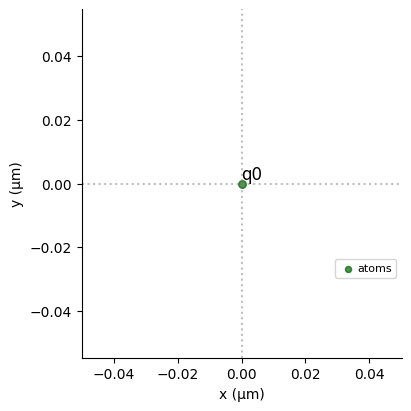

In [3]:
register = pulser.Register.from_coordinates([(0, 0)], prefix="q")
register.draw()

At this stage, we can initialize the `Sequence`, our quantum program. This will check that the created `Register` matches the parameters set by the `Device` we picked. 

In [4]:
sequence = pulser.Sequence(register, device)

### 3. Picking the Channels

The only channel we need to pick is a `Rydberg` channel to target the transition between $\left|g\right>$ and $\left|r\right>$. Since we only have one atom, the addressing does not matter, the `Rydberg.Global` channel will address the atom in the register. 

In [5]:
print("The available channels were", sequence.available_channels)
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The available channels were {'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.4333882308138, controlled_beams=(<RydbergBeam.BLUE: 1>,), mod_bandwidth=40, custom_buffer_time=240, multiple_beam_control=True, blue_shift_coeff=1.0, red_shift_coeff=1.0), propagation_dir=None)}
The states used in the computation are ['r', 'g']


At this stage, the atom is initialized in the ground state $\left|g\right>$ and only two energy levels are used in the computation - the state of the system is described by a qubit.

### 4. Adding the pulses

Let's now add the pulse of duration $\Delta t = 1000\ ns$, amplitude $\Omega=\pi\ rad/\mu s$, detuning $\delta=0$ and phase $\phi=0$ to the `Rydberg.Global` channel to modify the state of the atom and make it reach the state $\left|r\right>$.

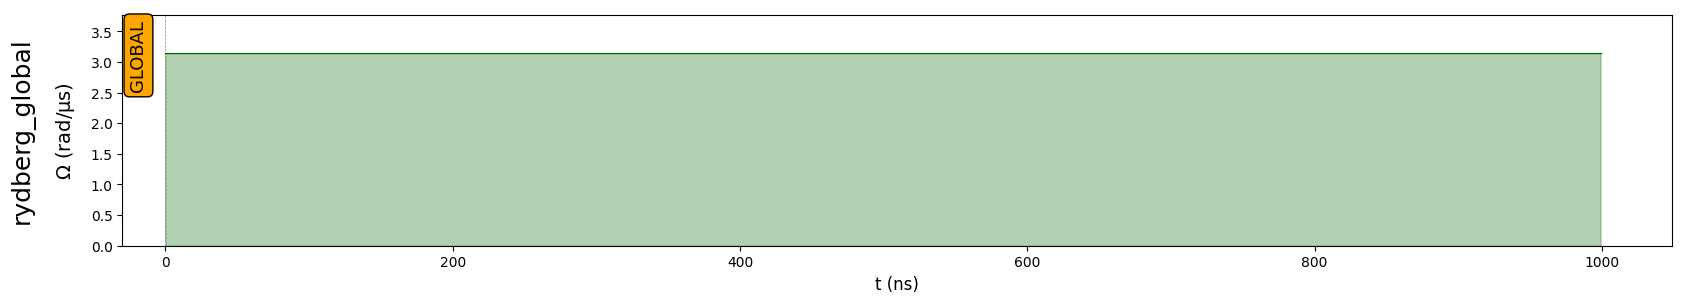

In [6]:
pi_pulse = pulser.Pulse.ConstantPulse(1000, np.pi, 0, 0)
sequence.add(pi_pulse, "rydberg_global")
sequence.draw(mode="input")

### Executing the Pulse Sequence

We are now done with our first Pulser program! We can now submit it to a backend for execution. Pulser provides multiple backends, notably the QPUs, but also a backend to simulate small quantum systems on your laptop based on **QuTip**. Let's use this `QutipBackend` to simulate the final state of the system: 

In [7]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()

When running an experiment on a neutral-atom QPU, the output of the quantum program is the sampling of the final state. It is a dictionnary associating to each measured state the number of times it was measured.

In [8]:
result.sample_final_state(1000)

Counter({'1': 1000})

When measuring in the ground-rydberg basis, [the ground state is labelled "0" and the rydberg state "1"](../conventions.md#state-preparation-and-measurement). For each of the 1000 measurements we did, the atom was measured in the Rydberg state, which means we designed our quantum program correctly !

## Adiabatic preparation of an Anti-Ferromagnetic State

Let's now program the [Ising Hamiltonian](../programming.md) such that a set of 9 atoms initially in the ground state $\left|ggggggggg\right>$ are prepared in an antiferromagnetic state $\left|rgrgrgrgr\right>$.

To reach the desired antiferromagentic state, we can take advantage of the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem). The idea is to use a time-dependent Hamiltonian that changes slowly so that the system stays in its ground state. Therefore, we must choose a final Hamiltonian that has the antiferromagnetic state as its ground state.

This final Hamiltonian should simultaneously favor having the largest number of atoms in the $\left|r\right>$ state (by having $\delta \ge 0$) and discourage nearest neighbors from being both in $\left|r\right>$ (via the  [interaction Hamiltonian](../programming.md)). When these contributions are appropriately balanced, we get an Hamiltonian with $\left|rgrgrgrgr\right>$ as its ground state.

Let's modify the parameters of the driving Hamiltonian slowly following [this protocol](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070):
<center>
<img src="../files/AF_Ising_program.png" alt="AF Pulse Sequence" width="300">
</center>

Let's assign to these parameters some values:

In [9]:
# Parameters in rad/µs
Omega_max = 2.0 * 2 * np.pi

delta_0 = -6 * Omega_max / 2
delta_f = 2 * Omega_max / 2

# Parameters in ns
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

### 1. Picking a `Device`

We need a `Device` that will enable us to target the transition between the ground and the rydberg state. As above, we select `pulser.AnalogDevice` since it contains the `Rydberg.Global` channel, that targets the transition between these two states.

In [10]:
device = pulser.AnalogDevice
print(device.specs)


Register parameters:
 - Dimensions: 2D
 - Rydberg level: 60
 - Maximum number of atoms: 25
 - Maximum distance from origin: 35 µm
 - Minimum distance between neighbouring atoms: 5 μm
 - SLM Mask: No

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: No
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Maximum number of runs: 2000
 - Maximum sequence duration: 4000 ns
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - Ising interaction coefficient: 865723.02

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.

### 2. Creating the `Register`

Let's follow the [protocol](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070) to create the `Register`. Let's place the atoms in a rectangular lattice, such that the distance between two neighbouring atoms is the same, and let's choose that distance such that $\hbar\Omega_{max}=2\frac{C_6}{R^6}$.

Interatomic Radius is: 7.186760677748386µm.


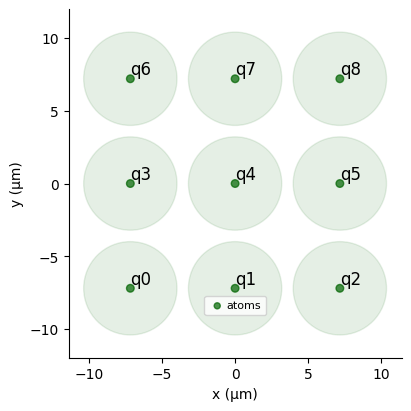

In [11]:
R_interatomic = device.rydberg_blockade_radius(Omega_max / 2)
N_side = 3
register = pulser.Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
register.draw(
    draw_half_radius=True,
    blockade_radius=device.rydberg_blockade_radius(Omega_max),
)

Note: `Device.rydberg_blockade_radius(Omega)` computes $R = (\frac{C_6}{\hbar \Omega})^{1/6}$, using the $C_6$ coefficient of the `Device`. The Rydberg Blockade Radius is the distance above which two atoms cannot be found both in the Rydberg state. This phenomenon is at the core of the entanglement process in cold-atom QPUs.

Let's now initialize our quantum program, the `Sequence`, and check that the created `Register` matches the parameters set by the `Device` we picked: 

In [12]:
sequence = pulser.Sequence(register, device)

### 3. Picking the Channels

The only channel we need to pick is a `Rydberg` channel to target the transition between $\left|g\right>$ and $\left|r\right>$. Since we want to apply the same amplitude, detuning and phase on each atom, we can use the `Rydberg.Global` channel: 

In [13]:
print("The available channels were", sequence.available_channels)
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The available channels were {'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.4333882308138, controlled_beams=(<RydbergBeam.BLUE: 1>,), mod_bandwidth=40, custom_buffer_time=240, multiple_beam_control=True, blue_shift_coeff=1.0, red_shift_coeff=1.0), propagation_dir=None)}
The states used in the computation are ['r', 'g']


At this stage, all the atoms are initialized in the state $\left|g\right>$ and only two energy levels are used in the computation: each atom is a qubit and the initial state of the quantum system is $\left|ggggggggg\right>$.

The interaction Hamiltonian is now completely determined, and will not change along time.

### 4. Adding the pulses

Let's now define the driving Hamiltonian at each nanosecond between $0$ and $t_{tot}=t_{rise}+t_{sweep}+t_{fall}$. We follow the program that we described above. The `Sequence` will be composed of three pulses:
- A first "rise" pulse of duration $t_{rise}$ during which the amplitude ramps from 0 to $\Omega_{max}$, while the detuning is equal to $\delta_0$ and the phase is constant equal to $0$.
- A second "sweep" pulse of duration $t_{sweep}$ during which the amplitude is constant equal to $\Omega_{max}$, the detuning ramps from $\delta_0$ to $\delta_{final}$, and the phase is constant equal to $0$.
- A third "fall" pulse of duration $t_{fall}$ during which the amplitude ramps down from $\Omega_{max}$ to $0$, the detuning is constant equal to $\delta_{final}$ and the phase is constant equal to $0$.  

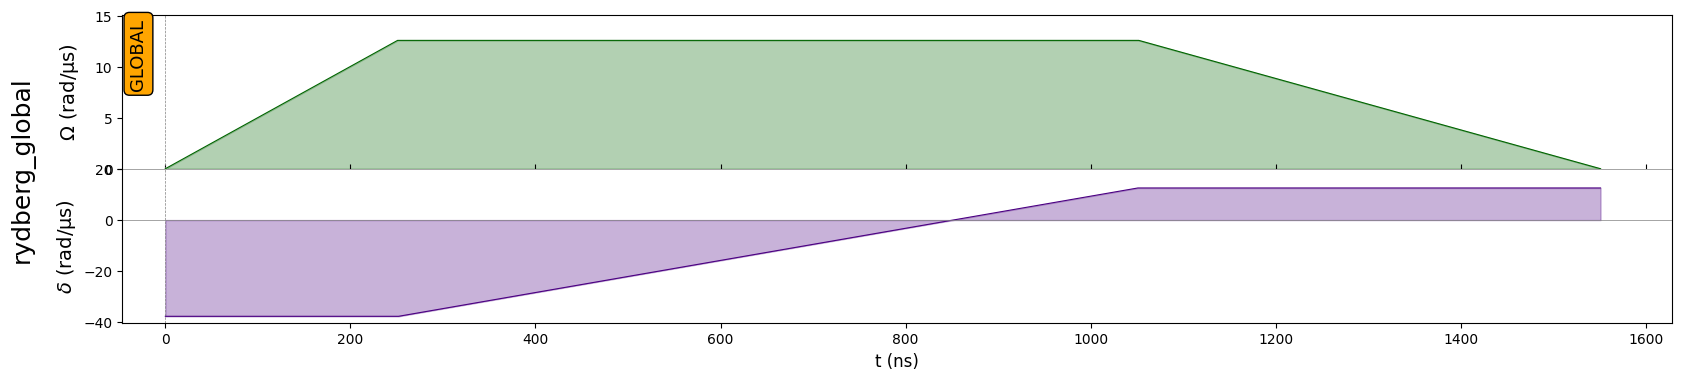

In [14]:
rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)
sequence.add(rise, "rydberg_global")
sequence.add(sweep, "rydberg_global")
sequence.add(fall, "rydberg_global")
sequence.draw(mode="input")

### Executing the Pulse Sequence

We are now done with this program! Let's use the `QutipBackend` to simulate the final state of the system: 

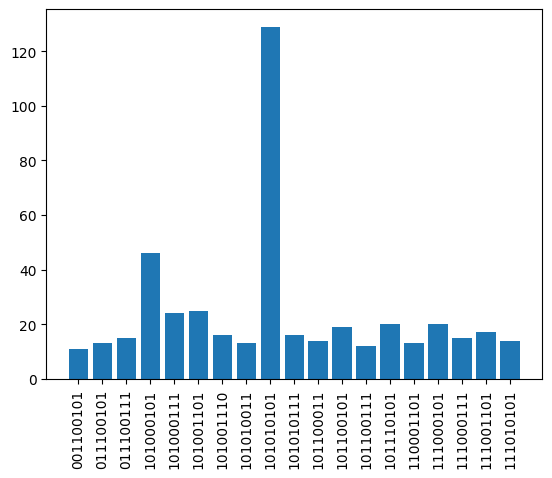

In [15]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()
counts = result.sample_final_state(1000)
# Let's plot the histogram associated to the measurements
# Let's select only the states that are measured more than 10 times
most_freq = {k: v for k, v in counts.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The state that is measured the most frequently is the $\left|101010101\right>\rightarrow\left|rgrgrgrgr\right>$: our quantum program correctly excites the ground sate $\left|ggggggggg\right>$ into the state $\left|rgrgrgrgr\right>$.